In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ccba = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_ccba_full_hashed.csv')
cdtx = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_cdtx0001_full_hashed.csv')
custinfo = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_custinfo_full_hashed.csv')
dp = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_dp_full_hashed.csv')
remit = pd.read_csv('/home/bill/moneylaundring/dataset/public_train_x_remit1_full_hashed.csv')
p_date = pd.read_csv('/home/bill/moneylaundring/dataset/public_x_alert_date.csv')
t_date = pd.read_csv('/home/bill/moneylaundring/dataset/train_x_alert_date.csv')
answer = pd.read_csv('/home/bill/moneylaundring/dataset/train_y_answer.csv')

cycam 為信用額度，取出每個 id 最大的信用額度

In [3]:
ccba_merge = ccba.groupby('cust_id')
new_ccba = ccba_merge['cycam'].max()
new_ccba = pd.DataFrame(new_ccba)
new_ccba

,cycam
cust_id,
0015cc01f553512007705edf855baa16f1b57a16fb107e0882c5cb0535d297a5,134614.0
002d6bc6382e759c9a5b6bb2c8dda9add2f38cd87e10ca3efda9a312e97b342c,406614.0
002f13f534d0bd9fcc1848db3ff5c7b1179d117f8de8055b7394696b948ec9b4,314421.0
0031e83ddef78e57d17ac5dce088627b7745be8ff6cffcbc0a79aff9fedd93f0,202831.0
0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155b9bc5d18de6b65f381,20238.0
...,...
ffa5bcc6f88df5c33e809da4daa54de0031803f37d8f114b0ce2a70519099edc,208683.0
ffae7fef923c78298cd647a3d573e48cc1404b07ac794a63f436399ceca4ed9d,208765.0
ffdbc1a5135cb6feddf7355e5656abf6973f21639c7b9b9c8a23f77a194369c9,203231.0


將信用額度與顧客資訊 merge 起來

In [4]:
cinfo = custinfo.merge(new_ccba,on='cust_id',how='outer')
cinfo = cinfo.merge(t_date, on='alert_key')
cinfo = cinfo.merge(answer, on='alert_key')

cycam 為信用額度, 將 na 值補 0 

In [5]:
cinfo['cycam'].fillna(0,inplace=True)

In [6]:
cinfo[cinfo['cycam'].isna()]

,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE,cycam,date,sar_flag


檢查是否還有欄位存在空值

In [7]:
cinfo.isna().any()

alert_key          False
cust_id            False
risk_rank          False
occupation_code     True
total_asset        False
AGE                False
cycam              False
date               False
sar_flag           False
dtype: bool

In [8]:
cinfo['occupation_code'].unique()

array([19.,  2., 17., 15., 12.,  9., 18.,  1., 14.,  3., 13.,  5., 10.,
       16., nan, 11.,  4.,  7.,  8., 20.,  0.,  6.])

occupation_code 為職業，已經存在 0 故以 21 替代空值

In [9]:
cinfo['occupation_code'].fillna(21,inplace=True)

In [10]:
cinfo.isna().any()

alert_key          False
cust_id            False
risk_rank          False
occupation_code    False
total_asset        False
AGE                False
cycam              False
date               False
sar_flag           False
dtype: bool

因為 sar_flag 是與 alert_key 和 date 共存
固與每種交易類型以 cust_id 和　date 合併

In [11]:
cdtx = pd.merge(cinfo, cdtx, left_on=['cust_id','date'], right_on=['cust_id','date'])
dp = pd.merge(cinfo, dp, left_on=['cust_id','date'], right_on=['cust_id','tx_date'])
remit = pd.merge(cinfo, remit, left_on=['cust_id','date'], right_on=['cust_id','trans_date'])

將 cust_id 和 alert_key 捨去因為這兩項對模型預測並無幫助

In [12]:
cdtx_X = cdtx[['risk_rank','occupation_code','total_asset','AGE','cycam','country','cur_type','amt','date']]
cdtx_y = cdtx[['sar_flag']]
cdtx_idx = cdtx[['alert_key']]

In [13]:
from sklearn.model_selection import train_test_split
cdtx_X_train, cdtx_X_test, cdtx_y_train, cdtx_y_test , cdtx_train_indices, cdtx_test_indices= train_test_split(cdtx_X, cdtx_y, cdtx_idx, test_size = 0.1, random_state=0)

將表中數值型資料與類別型分開

In [14]:
cdtx_X_train_num = cdtx_X_train[['total_asset','cycam','amt']]
cdtx_X_train_cat = cdtx_X_train[['risk_rank','occupation_code','AGE','country','cur_type','date']]

In [15]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer


def rfe_selection( X , Y, k=5):

    # Split train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, 
        Y, 
        test_size = 0.2, 
        stratify=Y, 
        random_state = 0)

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    

    model = RandomForestRegressor(
        criterion='squared_error', 
        random_state=0
        )
    rfe = RFE(model, n_features_to_select=k)
    rfe = rfe.fit(X_train, Y_train)

    feature_names = X.columns[rfe.get_support()]

    return feature_names

rfe_selection(cdtx_X_train,cdtx_y_train.values.ravel())

Index(['occupation_code', 'total_asset', 'cycam', 'amt', 'date'], dtype='object')

In [16]:
from sklearn.feature_selection import SelectKBest, chi2

In [18]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(cdtx_X_train_cat, cdtx_y_train)
X_train_fs = fs.transform(cdtx_X_train_cat)

Feature 0: 20.250229
Feature 1: 0.315595
Feature 2: 18.660862
Feature 3: 549.101845
Feature 4: 194.574380
Feature 5: 110.628524


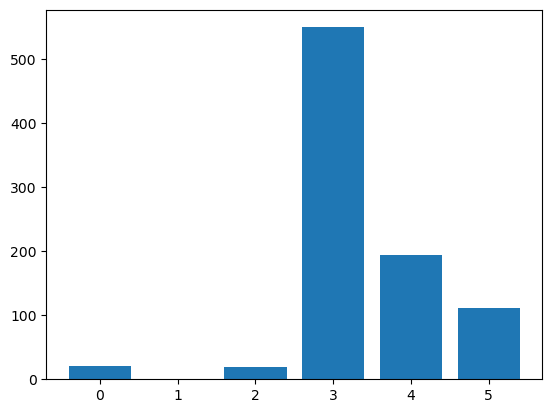

In [19]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

全部丟給 selectkbest - chi2

In [35]:
fs_all = SelectKBest(score_func=chi2, k='all')
fs_all.fit(cdtx_X_train, cdtx_y_train)
X_train_fs_all = fs_all.transform(cdtx_X_train)

Feature 0: 20.250229
Feature 1: 0.315595
Feature 2: 83861039.227092
Feature 3: 18.660862
Feature 4: 420451.432493
Feature 5: 549.101845
Feature 6: 194.574380
Feature 7: 83955.851872
Feature 8: 110.628524


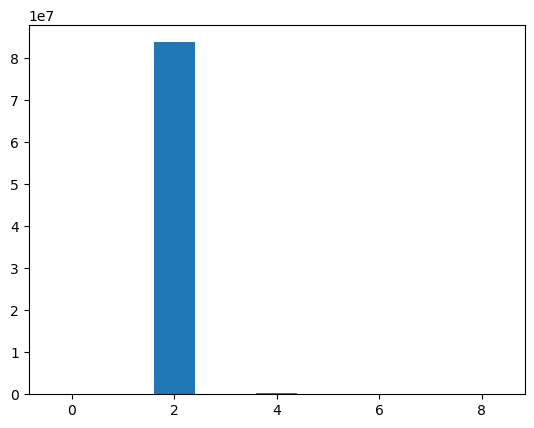

In [37]:
for i in range(len(fs_all.scores_)):
    print('Feature %d: %f' % (i, fs_all.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs_all.scores_))], fs_all.scores_)
plt.show()

cdtx_X = cdtx[['risk_rank','occupation_code','total_asset','AGE','cycam','country','cur_type','amt','date']]

In [40]:
cdtx_X_train_new6 = cdtx_X_train[['total_asset','cycam','country','cur_type','amt']]

In [41]:
cdtx_X_test_new6 = cdtx_X_test[['total_asset','cycam','country','cur_type','amt']]

In [43]:
cdtx_ct_new6 = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[2,3])], remainder='passthrough')
cdtx_X_train_new6_T = cdtx_ct_new6.fit_transform(cdtx_X_train_new6)
cdtx_X_test_new6_T = cdtx_ct_new6.transform(cdtx_X_test_new6)

In [44]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# classifier = RandomForestClassifier(n_estimators=100, criterion='log_loss', random_state=0)
# classifier.fit(X_train, y_train.values.ravel())
cdtx_classfier_new6 = RandomForestClassifier(n_estimators=100, criterion='entropy',random_state=0)
cdtx_classfier_new6.fit(cdtx_X_train_new6_T, cdtx_y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cdtx_y_pred_new6 = cdtx_classfier_new6.predict(cdtx_X_test_new6_T)
cdtx_cm_new6 = confusion_matrix(cdtx_y_test, cdtx_y_pred_new6)
print(cdtx_cm_new6)

[[4763    0]
 [  19   29]]


只取數值欄位

In [30]:
cdtx_X_train_new5 = cdtx_X_train[['total_asset','cycam','amt']]

In [33]:
cdtx_X_test_new5 = cdtx_X_test[['total_asset','cycam','amt']]

In [31]:
cdtx_classfier_new5 = RandomForestClassifier(n_estimators=100, criterion='entropy',random_state=0)
cdtx_classfier_new5.fit(cdtx_X_train_new5, cdtx_y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cdtx_y_pred_new5 = cdtx_classfier_new5.predict(cdtx_X_test_new5)

cdtx_cm_new5 = confusion_matrix(cdtx_y_test, cdtx_y_pred_new5)
print(cdtx_cm_new5)

[[4763    0]
 [  20   28]]


全部使用 rfe 篩選欄位

In [20]:
cdtx_X_train_new4 = cdtx_X_train[['occupation_code','total_asset','cycam','amt','date']]

In [21]:
cdtx_X_train_new4

,occupation_code,total_asset,cycam,amt,date
20227,19.0,1330.0,307001.0,36073.0,125
13858,12.0,517214.0,418264.0,117114.0,36
7643,12.0,5691.0,72435.0,8.0,363
31207,18.0,867571.0,312011.0,209.0,62
37784,12.0,6401.0,250274.0,12914.0,216
...,...,...,...,...,...
21243,18.0,991292.0,312011.0,214.0,20
45891,17.0,0.0,803500.0,85222.0,351
42613,9.0,1561931.0,102925.0,196.0,154
43567,17.0,270797.0,305944.0,117.0,180


In [22]:
cdtx_X_test_new4 = cdtx_X_test[['occupation_code','total_asset','cycam','amt','date']]

In [23]:
cdtx_X_test_new4

,occupation_code,total_asset,cycam,amt,date
15362,9.0,2287681.0,1503243.0,2336.0,20
21928,18.0,991292.0,312011.0,12840.0,26
46113,12.0,27396.0,201307.0,813.0,267
32837,12.0,326296.0,292963.0,5737.0,117
24270,18.0,797756.0,312011.0,212.0,35
...,...,...,...,...,...
41021,19.0,160933.0,402038.0,86214.0,194
19784,19.0,332090.0,522800.0,1031.0,99
9746,17.0,2815277.0,402456.0,332.0,348
13948,12.0,517214.0,418264.0,125479.0,42


In [24]:
cdtx_ct_new4 = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[1,4])], remainder='passthrough')
cdtx_X_train_new4_T = cdtx_ct_new4.fit_transform(cdtx_X_train_new4)
cdtx_X_test_new4_T = cdtx_ct_new4.transform(cdtx_X_test_new4)

In [25]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# classifier = RandomForestClassifier(n_estimators=100, criterion='log_loss', random_state=0)
# classifier.fit(X_train, y_train.values.ravel())
cdtx_classfier_new4 = RandomForestClassifier(n_estimators=100, criterion='entropy',random_state=0)
cdtx_classfier_new4.fit(cdtx_X_train_new4_T, cdtx_y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cdtx_y_pred_new4 = cdtx_classfier_new4.predict(cdtx_X_test_new4_T)
cdtx_y_pred_new4
#cdtx_cm_new4 = confusion_matrix(cdtx_y_test, cdtx_y_pred_new4)
# print(cdtx_cm_new4)

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
cdtx_y_test

,sar_flag
15362,0
21928,0
46113,0
32837,0
24270,0
...,...
41021,0
19784,0
9746,0
13948,0


In [29]:
cdtx_cm_new4 = confusion_matrix(cdtx_y_test, cdtx_y_pred_new4)
print(cdtx_cm_new4)

[[4763    0]
 [   6   42]]


依據分數，第一種欄位取法選擇捨去 fs_score 小於 100

In [141]:
cdtx_X_train_new = cdtx_X_train[['total_asset','cycam','country','cur_type','amt','date']]

In [142]:
cdtx_X_train_new

,total_asset,cycam,country,cur_type,amt,date
20227,1330.0,307001.0,130,47,36073.0,125
13858,517214.0,418264.0,130,47,117114.0,36
7643,5691.0,72435.0,59,16,8.0,363
31207,867571.0,312011.0,134,30,209.0,62
37784,6401.0,250274.0,130,47,12914.0,216
...,...,...,...,...,...,...
21243,991292.0,312011.0,134,30,214.0,20
45891,0.0,803500.0,135,46,85222.0,351
42613,1561931.0,102925.0,130,47,196.0,154
43567,270797.0,305944.0,130,47,117.0,180


In [143]:
cdtx_X_test_new = cdtx_X_test[['total_asset','cycam','country','cur_type','amt','date']]

In [144]:
cdtx_X_test_new

,total_asset,cycam,country,cur_type,amt,date
15362,2287681.0,1503243.0,130,47,2336.0,20
21928,991292.0,312011.0,52,13,12840.0,26
46113,27396.0,201307.0,44,47,813.0,267
32837,326296.0,292963.0,135,46,5737.0,117
24270,797756.0,312011.0,134,30,212.0,35
...,...,...,...,...,...,...
41021,160933.0,402038.0,130,47,86214.0,194
19784,332090.0,522800.0,43,47,1031.0,99
9746,2815277.0,402456.0,130,47,332.0,348
13948,517214.0,418264.0,130,47,125479.0,42


將類別型欄位進行 OneHotEncoding

In [145]:
cdtx_ct_new = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[1,2,4])], remainder='passthrough')
cdtx_X_train_new_T = cdtx_ct_new.fit_transform(cdtx_X_train_new)
cdtx_X_test_new_T = cdtx_ct_new.transform(cdtx_X_test_new)

In [146]:
cdtx_X_train_new_T

<43296x9077 sparse matrix of type '<class 'numpy.float64'>'
	with 254550 stored elements in Compressed Sparse Row format>

In [147]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# classifier = RandomForestClassifier(n_estimators=100, criterion='log_loss', random_state=0)
# classifier.fit(X_train, y_train.values.ravel())
cdtx_classfier_new = RandomForestClassifier(n_estimators=100, criterion='entropy',random_state=0)
cdtx_classfier_new.fit(cdtx_X_train_new_T, cdtx_y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [148]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
cdtx_y_pred_new = cdtx_classfier_new.predict(cdtx_X_test_new_T)
cdtx_y_pred_new
# cdtx_cm_new = confusion_matrix(cdtx_y_test, cdtx_y_pred_new)
# print(cdtx_cm_new)


array([0, 0, 0, ..., 0, 0, 0])

In [149]:
cdtx_new = pd.DataFrame(cdtx_y_test)

In [150]:
cdtx_new

,sar_flag
15362,0
21928,0
46113,0
32837,0
24270,0
...,...
41021,0
19784,0
9746,0
13948,0


In [151]:

cdtx_new['y_pred'] = cdtx_y_pred_new

In [152]:
cdtx_new

,sar_flag,y_pred
15362,0,0
21928,0,0
46113,0,0
32837,0,0
24270,0,0
...,...,...
41021,0,0
19784,0,0
9746,0,0
13948,0,0


預測與實際不同

In [153]:
cdtx_new[cdtx_new['sar_flag']!=cdtx_new['y_pred']]

,sar_flag,y_pred
39913,1,0
17457,1,0
33127,1,0
17567,1,0
41843,1,0
33208,1,0
40628,1,0
39912,1,0


In [154]:
print('Test set Accuracy: {:.2f} %'.format(accuracy_score(cdtx_y_test, cdtx_y_pred_new)*100))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

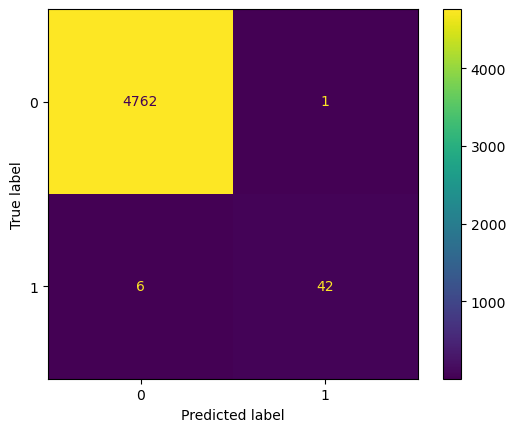

In [ ]:
cdtx_display1 = ConfusionMatrixDisplay(confusion_matrix=cdtx_cm_new)
cdtx_display1.plot()
plt.show()

第二種選擇 fs_score > 0

In [ ]:
cdtx_X_train_new2 = cdtx_X_train[['risk_rank','AGE','total_asset','cycam','country','cur_type','amt','date']]

In [ ]:
cdtx_X_train_new2

,risk_rank,AGE,total_asset,country,cur_type,amt,date
20227,1,5,1330.0,130,47,36073.0,125
13858,3,3,517214.0,130,47,117114.0,36
7643,1,2,5691.0,59,16,8.0,363
31207,3,3,867571.0,134,30,209.0,62
37784,1,2,6401.0,130,47,12914.0,216
...,...,...,...,...,...,...,...
21243,3,3,991292.0,134,30,214.0,20
45891,1,3,0.0,135,46,85222.0,351
42613,1,2,1561931.0,130,47,196.0,154
43567,2,3,270797.0,130,47,117.0,180


In [ ]:
cdtx_X_test_new2 = cdtx_X_test[['risk_rank','AGE','total_asset','cycam','country','cur_type','amt','date']]
cdtx_X_test_new2

,risk_rank,AGE,total_asset,country,cur_type,amt,date
15362,1,6,2287681.0,130,47,2336.0,20
21928,3,3,991292.0,52,13,12840.0,26
46113,1,3,27396.0,44,47,813.0,267
32837,1,2,326296.0,135,46,5737.0,117
24270,3,3,797756.0,134,30,212.0,35
...,...,...,...,...,...,...,...
41021,1,3,160933.0,130,47,86214.0,194
19784,3,3,332090.0,43,47,1031.0,99
9746,3,5,2815277.0,130,47,332.0,348
13948,3,3,517214.0,130,47,125479.0,42


In [ ]:
cdtx_ct_new2 = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[0,1,3,4,6])], remainder='passthrough')
cdtx_X_train_new2_T = cdtx_ct_new.fit_transform(cdtx_X_train_new2)
cdtx_X_test_new2_T = cdtx_ct_new.transform(cdtx_X_test_new2)

In [ ]:
cdtx_X_train_new2_T

<43296x2093 sparse matrix of type '<class 'numpy.float64'>'
	with 302741 stored elements in Compressed Sparse Row format>

In [ ]:
# classifier = RandomForestClassifier(n_estimators=100, criterion='log_loss', random_state=0)
# classifier.fit(X_train, y_train.values.ravel())
cdtx_classfier_new2 = RandomForestClassifier(n_estimators=100, criterion='entropy',random_state=0)
cdtx_classfier_new2.fit(cdtx_X_train_new2_T, cdtx_y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
cdtx_y_pred_new2 = cdtx_classfier_new2.predict(cdtx_X_test_new2_T)
cdtx_cm_new2= confusion_matrix(cdtx_y_test, cdtx_y_pred_new2)

print(cdtx_cm_new2)


[[4763    0]
 [   7   41]]


In [ ]:
print('Test set Accuracy: {:.2f} %'.format(accuracy_score(cdtx_y_test, cdtx_y_pred_new2)*100))

Test set Accuracy: 99.88 %


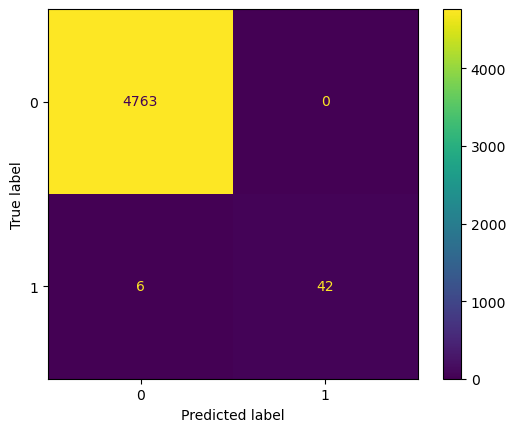

In [ ]:
cdtx_display2 = ConfusionMatrixDisplay(confusion_matrix=cdtx_cm_new2)
cdtx_display2.plot()
plt.show()

第三種選擇 fs_score 前兩名

In [ ]:
cdtx_X_train_new3 = cdtx_X_train[['country','cur_type','total_asset','cycam','amt']]

In [ ]:
cdtx_X_train_new3

,country,cur_type,total_asset,cycam,amt
20227,130,47,1330.0,307001.0,36073.0
13858,130,47,517214.0,418264.0,117114.0
7643,59,16,5691.0,72435.0,8.0
31207,134,30,867571.0,312011.0,209.0
37784,130,47,6401.0,250274.0,12914.0
...,...,...,...,...,...
21243,134,30,991292.0,312011.0,214.0
45891,135,46,0.0,803500.0,85222.0
42613,130,47,1561931.0,102925.0,196.0
43567,130,47,270797.0,305944.0,117.0


In [ ]:
cdtx_X_test_new3 = cdtx_X_test[['country','cur_type','total_asset','cycam','amt']]
cdtx_X_test_new3

,country,cur_type,total_asset,amt
15362,130,47,2287681.0,2336.0
21928,52,13,991292.0,12840.0
46113,44,47,27396.0,813.0
32837,135,46,326296.0,5737.0
24270,134,30,797756.0,212.0
...,...,...,...,...
41021,130,47,160933.0,86214.0
19784,43,47,332090.0,1031.0
9746,130,47,2815277.0,332.0
13948,130,47,517214.0,125479.0


In [ ]:
cdtx_ct_new3 = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'),[0,1])], remainder='passthrough')
cdtx_X_train_new3_T = cdtx_ct_new3.fit_transform(cdtx_X_train_new3)
cdtx_X_test_new3_T = cdtx_ct_new3.transform(cdtx_X_test_new3)

In [ ]:
cdtx_X_train_new3_T

<43296x91 sparse matrix of type '<class 'numpy.float64'>'
	with 168762 stored elements in Compressed Sparse Row format>

In [ ]:
cdtx_classfier_new3 = RandomForestClassifier(n_estimators=100, criterion='entropy',random_state=0)
cdtx_classfier_new3.fit(cdtx_X_train_new3_T, cdtx_y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
cdtx_y_pred_new3 = cdtx_classfier_new3.predict(cdtx_X_test_new3_T)
cdtx_cm_new3= confusion_matrix(cdtx_y_test, cdtx_y_pred_new3)

print(cdtx_cm_new3)

[[4763    0]
 [  20   28]]


In [ ]:
print('Test set Accuracy: {:.2f} %'.format(accuracy_score(cdtx_y_test, cdtx_y_pred_new3)*100))

Test set Accuracy: 99.61 %


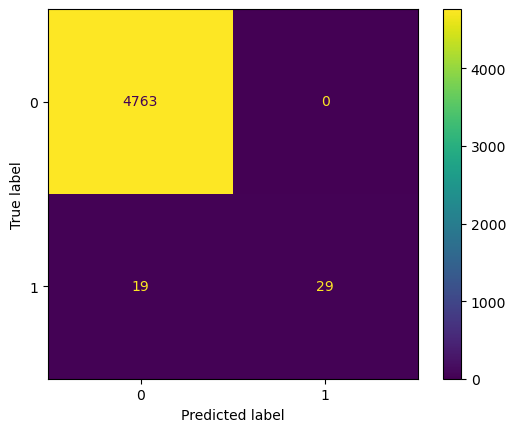

In [ ]:
cdtx_display3 = ConfusionMatrixDisplay(confusion_matrix=cdtx_cm_new3)
cdtx_display3.plot()
plt.show()

由上述可知, 隨著欄位的減少, 對於是洗錢行為的交易判斷能力越來越差